In [1]:
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
with fits.open('DistantClustersGaia_GALEX_SDSS_Skymapper_2MASS_WISE_ASASSN.fits') as hdu:
    asn_table = Table(hdu[1].data)
df = asn_table.to_pandas()

#Extract a cluster
list(df.columns)


['dr2_source_id',
 'dr3_source_id',
 'Cluster',
 'plx_cluster',
 'e_plx_cluster',
 'SimbadName_cluster',
 'skymapper_id',
 'sdss_id',
 'twomass_id',
 'allwise_id',
 'ra2000',
 'dec2000',
 'gmag',
 'bpmag',
 'dr2_bp_flux_over_error',
 'rpmag',
 'dr2_rp_flux_over_error',
 'parallax',
 'parallax_error',
 'ruwe',
 'phot_g_mean_flux',
 'phot_g_mean_flux_error',
 'phot_g_n_obs',
 'gmag_edr3',
 'bpmag_edr3',
 'rpmag_edr3',
 'r_lo_geo',
 'r_med_geo',
 'r_hi_geo',
 'r_lo_photogeo',
 'r_med_photogeo',
 'r_hi_photogeo',
 'objid_FUV',
 'FUVmag',
 'e_FUVmag',
 'Fafl',
 'objid_NUV',
 'NUVmag',
 'e_NUVmag',
 'Nafl',
 'psfMag_uSDSS',
 'psfMagErr_uSDSS',
 'psfMag_gSDSS',
 'psfMagErr_gSDSS',
 'psfMag_rSDSS',
 'psfMagErr_rSDSS',
 'psfMag_iSDSS',
 'psfMagErr_iSDSS',
 'psfMag_zSDSS',
 'psfMagErr_zSDSS',
 'u_flags',
 'u_nimaflags',
 'u_ngood',
 'u_psf',
 'e_u_psf',
 'v_flags',
 'v_nimaflags',
 'v_ngood',
 'v_psf',
 'e_v_psf',
 'g_flags',
 'g_nimaflags',
 'g_ngood',
 'g_psf',
 'e_g_psf',
 'r_flags',
 'r_nima

In [3]:
df_NGC = df[(df['Cluster']=='NGC2682 ')]

In [4]:
df_NGC.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)

<ipython-input-4-557ff63e5e39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_NGC.dropna(subset = ['gmag','rpmag','bpmag'], inplace = True)


In [5]:
# allocate data for g_magnitude and bp-rp to x and y
x = np.array(df_NGC['gmag'])
y = np.array(df_NGC['bpmag']- df_NGC['rpmag'])
x_s1 = []
y_s1=[]
x_s2 = []
y_s2 = []
for i in range(len(x)):
    if x[i] >=13 and y[i] >=0.7:
        x_s1.append(x[i])
        y_s1.append(y[i])
    elif (0.70 <= y[i]<=0.78) and x[i] >=12.5:
        x_s1.append(x[i])
        y_s1.append(y[i])
    else:
        x_s2.append(x[i])
        y_s2.append(y[i])


In [6]:
model = np.polyfit(x_s1, y_s1, 10)
print(model)

[ 3.53422271e-13 -1.28095735e-11 -2.62234341e-10 -1.06119989e-09
  7.73894636e-08  2.61150267e-06  4.17784314e-05  6.93447544e-05
 -1.50373139e-02 -3.23550942e-01  5.17638178e+00]


/Users/chris.w/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


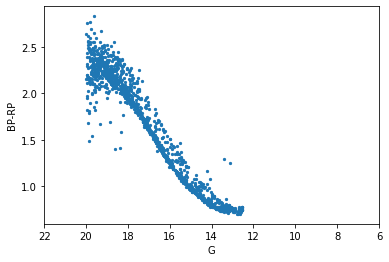

In [7]:
#draw the scatter plot for the two sets of data
plt.scatter(x_s1, y_s1, s = 5)
plt.xlim(22,6)
plt.xlabel('G')
plt.ylabel('BP-RP')
plt.show()

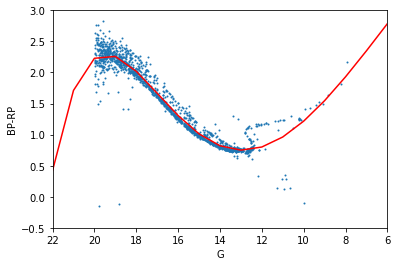

In [8]:
# Get y values that correspond to the linear regression model
predict = np.poly1d(model)
x_lin_reg = range(6, 23)
y_lin_reg = predict(x_lin_reg)

plt.xlim(22,6)
plt.ylim(-0.5,3)
plt.scatter(x, y, s = 1)
plt.xlabel('G')
plt.ylabel('BP-RP')
# adapt the fitted line to the scatter plot
plt.plot(x_lin_reg, y_lin_reg, c = 'r')
plt.show()

In [9]:
# get every y values in the linear regresssion model that corresponds to the g_band magnitudes
predicted = np.arange(len(x_s1), dtype=float)
for i in range(len(np.array(x_s1))):
    predicted[i] = predict(np.array(x_s1)[i])
predicted

array([0.79736981, 2.2562747 , 1.19057411, ..., 2.19838082, 2.11423444,
       0.75341391])

In [10]:
# get the difference between the values predicted by the model and the actual bp-rp values
diff = y_s1 - predicted

#get the standard deviation of the differences
sigma = []
precision = 0
for i in range(len(x_s1)):
    if x_s1[i] <13:
        precision = 2*(10**(-3))
    elif x_s1[i] < 18:
        precision = 10*(10**(-3))
    else:
        precision = 200*(10**(-3))
    sigma.append(np.sqrt(2*precision**2))
sigma = np.array(sigma)

In [11]:
# Extract the outliers
outliers_5sigma = [] #outliers outside of the 2 sigma value
y_5sigma = [] # corresponding bp-rp values
outliers_2sigma = [] #outliers outside of the 1.5 sigma value
y_2sigma = [] # corresponding bp-rp values
outliers_1sigma = []#outliers outside of the 1 sigma value
y_1sigma = [] # corresponding bp-rp values
x_filtered = []
y_filtered = []


for i in range(len(diff)):
    if diff[i] >= 5*sigma[i]:
        outliers_5sigma.append(x_s1[i])
        y_5sigma.append(y_s1[i])
    
    elif diff[i] >= 2*sigma[i]:
        outliers_2sigma.append(x_s1[i])
        y_2sigma.append(y_s1[i])
    elif diff[i] >= sigma[i]:
        outliers_1sigma.append(x_s1[i])
        y_1sigma.append(y_s1[i])
        
    else:
        x_filtered.append(x_s1[i])
        y_filtered.append(y_s1[i])
        
        
# convert the lists to numpy arrays
outliers_5sigma = np.array(outliers_5sigma)

outliers_2sigma = np.array(outliers_2sigma)
outliers_1sigma = np.array(outliers_1sigma)


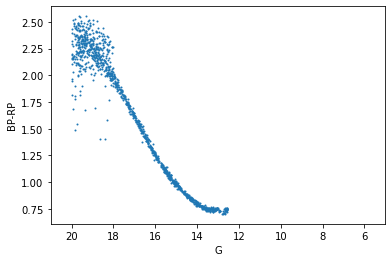

In [12]:
# plot the good values
plt.scatter(x_filtered, y_filtered, s=1)
plt.xlim(21,5)
plt.xlabel('G')
plt.ylabel('BP-RP')
plt.show()

In [13]:
print(len(x_filtered))
print(len(outliers_1sigma))

1184
39


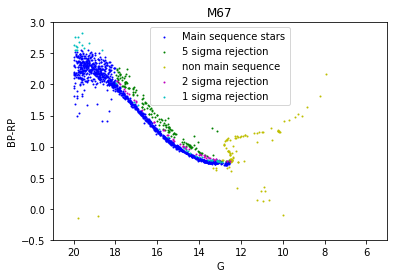

In [14]:
# plot the good values alongside the rejected values and the fitted line
plt.xlim(21,5)
plt.ylim(-0.5,3)
plt.scatter(x_filtered, y_filtered, c = 'b', label = 'Main sequence stars', s = 1)
plt.scatter(outliers_5sigma, y_5sigma, c = 'g', label = '5 sigma rejection', s=1)
plt.scatter(x_s2, y_s2, c = 'y', label = "non main sequence", s=1)
plt.scatter(outliers_2sigma, y_2sigma, c = 'm',label = '2 sigma rejection', s=1)
plt.scatter(outliers_1sigma, y_1sigma, c='c', label = '1 sigma rejection',s=1)
plt.xlabel('G')
plt.ylabel('BP-RP')
#plt.plot(x_lin_reg, y_lin_reg, c = 'r', label='Fitted line')
plt.title('M67')
plt.legend()
plt.show()

In [19]:
x_s3=[]
y_s3 = []
for i in range(len(x_filtered)):
    if x_filtered[i] <=18:
        x_s3.append(x_filtered[i])
        y_s3.append(y_filtered[i])

In [20]:
len(x_s3)

708

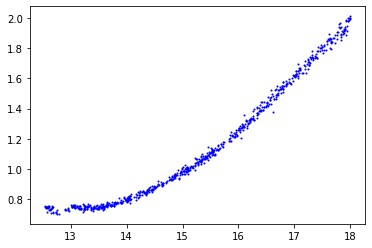

In [21]:
plt.scatter(x_s3, y_s3, c = 'b', label = 'Main sequence stars', s = 1)

In [22]:
csv_list = [[] for w in range(len(x_s3))]
for i in range(0, len(x_s3)):
    csv_list[i].append(x_s3[i])
    csv_list[i].append(y_s3[i])
csv_list = np.array(csv_list)

In [23]:
df1=df_NGC[df_NGC['gmag']==x_s3[0]]
df2 = df_NGC[df_NGC['gmag']==x_s3[1]]
df1.append(df2, ignore_index=True)

,dr2_source_id,dr3_source_id,Cluster,plx_cluster,e_plx_cluster,SimbadName_cluster,skymapper_id,sdss_id,twomass_id,allwise_id,...,cc_flags_WISE,ext_flg_WISE,ph_qual_WISE,moon_lev_WISE,asassn_name,Mean Vmag_ASASSN,amplitude_ASASSN,period_ASASSN,Type_ASASSN,class_probability_ASASSN
0,598591692283221248,598591692283221248,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237671261198418157,08513289+1047286,J085132.88+104728.6,...,0000,0,AABU,0000,,NaN,NaN,NaN,,NaN
1,598619935988243840,598619935988243840,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237671261198614634,08530834+1055176,J085308.33+105517.5,...,0000,0,AAUU,0000,,NaN,NaN,NaN,,NaN


In [24]:
DF = df_NGC[df_NGC['gmag']==x_s3[0]]
for i in range(1, len(x_s3)):
    df2 = df_NGC[df_NGC['gmag']==x_s3[i]]
    DF = DF.append(df2, ignore_index=True)

In [25]:
DF

,dr2_source_id,dr3_source_id,Cluster,plx_cluster,e_plx_cluster,SimbadName_cluster,skymapper_id,sdss_id,twomass_id,allwise_id,...,cc_flags_WISE,ext_flg_WISE,ph_qual_WISE,moon_lev_WISE,asassn_name,Mean Vmag_ASASSN,amplitude_ASASSN,period_ASASSN,Type_ASASSN,class_probability_ASASSN
0,598591692283221248,598591692283221248,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237671261198418157,08513289+1047286,J085132.88+104728.6,...,0000,0,AABU,0000,,NaN,NaN,NaN,,NaN
1,598619935988243840,598619935988243840,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237671261198614634,08530834+1055176,J085308.33+105517.5,...,0000,0,AAUU,0000,,NaN,NaN,NaN,,NaN
2,598621443521529216,598621443521529216,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237671261198614659,08531135+1056051,J085311.34+105604.9,...,0000,0,AAUU,0000,,NaN,NaN,NaN,,NaN
3,598623990437231872,598623990437231872,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237671261198549166,08522012+1058018,,...,,-2147483648,,,,NaN,NaN,NaN,,NaN
4,598658242801192192,598658242801192192,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237671124296401043,08495957+1055545,J084959.56+105554.4,...,0000,0,AACU,0000,,NaN,NaN,NaN,,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,608028010310445056,608028010310445056,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237670965382217798,08500471+1230341,J085004.70+123034.0,...,0000,0,AAUU,0000,,NaN,NaN,NaN,,NaN
704,608035152841386240,608035152841386240,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237670965382283318,08503798+1237299,J085037.97+123729.9,...,0000,0,AABU,0000,,NaN,NaN,NaN,,NaN
705,608038764908563968,608038764908563968,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237670965382152265,08492976+1230078,,...,,-2147483648,,,,NaN,NaN,NaN,,NaN
706,608039138570280064,608039138570280064,NGC2682,1.1325,0.0011,NGC2682,-9223372036854775808,1237670965382152390,08492813+1232088,J084928.13+123208.6,...,0000,0,AAUU,0000,,NaN,NaN,NaN,,NaN


In [26]:
DF.to_csv('M67.csv', index=False)